# Split Data

Dataset:
  - Multiple time series: stocks, not iid
  - Predict target: price movement index 60 seconds later in the last 10 mins (Prediction Horizon is 60 seconds)
  - Split & Autoregressive features: Time series split by date_id:
    1. The dataset have grouped structure, is time series, and not iid
    2. Structure: date_id --> seconds in bucket (always 55 values for each day) --> stock_id (191-200 stocks in each time bucket)
    3. To follow real-world and competetion setting, we should make sure that:
       - For each record, only previous day target information (55 time buckets for each stock) will be revealed.
       - That means we cannot create inproper lags: e.g., lag within the same day
       - Also means that we should splited based on date_id & time series
       - And same stock on same day will have the same set of lagged target data
       - This is because it's possible that the synthetic index used in the target won't be calculated until the end of the day.
   - Method: python extension for grouped time series split
   - Note: in this case, the training & validation date will be continuous, but there will be time gap between the training and testing set! Though that might affect our model performance, it might be how the real-world & competition setting goes, I suggest to keep this. For this reason, I will also not create lagged feature for columns other than the target.

We will first construct auto-regressive target data for previous 1 day as stated, then perform time series splits based on date_id.

## Add lagged features

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

data = pd.read_csv('../data/raw_kaggle/train.csv')

identifier_cols = ['time_id', 'row_id']
features = ['stock_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 
            'reference_price', 'matched_size', 'far_price', 'near_price', 
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',]
date_col, target_col = 'date_id', 'target'
lagged_cols = [f'lagged_target_1d_{i}' for i in range(0, 541, 10)]
cols = identifier_cols + [date_col] + features + lagged_cols + [target_col]

In [2]:
# Construct lagged features
df_lagged = data[['stock_id', 'date_id', 'seconds_in_bucket', 'target']].sort_values(by=['stock_id', 'date_id'])
df_pivot = df_lagged.pivot(index=['stock_id', 'date_id'], columns='seconds_in_bucket', values='target').reset_index()

stock_list = data[['stock_id']].drop_duplicates().sort_values(by='stock_id').reset_index(drop=True)
date_list =  data[['date_id']].drop_duplicates().sort_values(by='date_id').reset_index(drop=True)
df_expanded = pd.merge(stock_list, date_list, how='cross')
df_expanded = pd.merge(df_expanded, df_pivot, how='left', on=['stock_id', 'date_id'])

for i in range(0, 541, 10):
    df_expanded = df_expanded.rename(columns={i: f'lagged_target_1d_{i}'})

df_lagged = df_expanded.copy()

for i in range(0, 541, 10):
    df_lagged[f'lagged_target_1d_{i}'] = df_lagged.groupby('stock_id')[f'lagged_target_1d_{i}'].shift()

data_new = data.merge(df_lagged, how='left', on=['stock_id', 'date_id'])[cols]

## Data Description After Adding Lagged Data

At this stage, we have 72 columns and 5237980 columns:
- 1 target column
- 2 identifier columns (time_id, row_id): will be saved and dropped later, not entering model
- 3 id columns (stock_id, date_id, stock_id): date_id will also be dropped after spliting data
- 55 of the columns are lagged data
- 11 original market features

In [3]:
display(data_new.head())
print(data_new.shape)

,time_id,row_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,lagged_target_1d_0,lagged_target_1d_10,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_90,lagged_target_1d_100,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_190,lagged_target_1d_200,lagged_target_1d_210,lagged_target_1d_220,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_250,lagged_target_1d_260,lagged_target_1d_270,lagged_target_1d_280,lagged_target_1d_290,lagged_target_1d_300,lagged_target_1d_310,lagged_target_1d_320,lagged_target_1d_330,lagged_target_1d_340,lagged_target_1d_350,lagged_target_1d_360,lagged_target_1d_370,lagged_target_1d_380,lagged_target_1d_390,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_450,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_540,target
0,0,0_0_0,0,0,0,3180602.6900,1,0.9998,13380276.6400,NaN,NaN,0.9998,60651.5000,1.0000,8493.0300,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0297
1,0,0_0_1,0,1,0,166603.9100,-1,0.9999,1642214.2500,NaN,NaN,0.9999,3233.0400,1.0007,20605.0900,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5200
2,0,0_0_2,0,2,0,302879.8700,-1,0.9996,1819368.0300,NaN,NaN,0.9994,37956.0000,1.0003,18995.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.3900
3,0,0_0_3,0,3,0,11917682.2700,-1,1.0002,18389745.6200,NaN,NaN,1.0000,2324.9000,1.0002,479032.4000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0102
4,0,0_0_4,0,4,0,447549.9600,-1,0.9995,17860614.9500,NaN,NaN,0.9994,16485.5400,1.0000,434.1000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.3498


(5237980, 72)


## Split Test Data

Other index: [      0       1       2 ... 4181977 4181978 4181979] TEST index: [4181980 4181981 4181982 ... 5237977 5237978 5237979]


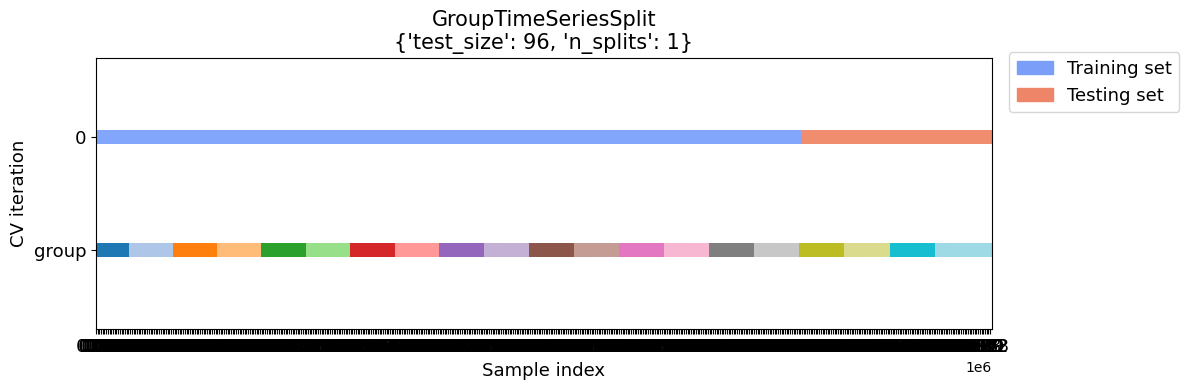

Train indices: [      0       1       2 ... 4181977 4181978 4181979]
Test indices: [4181980 4181981 4181982 ... 5237977 5237978 5237979]
Train length: 4181980
Test length: 1056000
Train groups: [  0   0   0 ... 384 384 384]
Test groups: [385 385 385 ... 480 480 480]
Train group size: 385
Test group size: 96
Train group months: [      0       1       2 ... 4181977 4181978 4181979]
Test group months: [4181980 4181981 4181982 ... 5237977 5237978 5237979]



In [4]:
# Prepare data
X = data_new[identifier_cols+features+lagged_cols]
y = data_new[target_col]
groups = data_new[date_col]

# Split test data
len_group = groups.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group*0.2), n_splits=1)
for i_other, i_test in gts.split(X, y, groups):
    print("Other index:", i_other, "TEST index:", i_test)
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

# Visulization
cv_args = {"test_size": int(len_group*0.2), "n_splits": 1}
plot_splits(X, y, groups, **cv_args)
print_split_info(X, y, groups, **cv_args)

The train-validation split will be done together with preprocessing after exploring the missing data!

# Preprocessing

- We do not fill missing values at this stage: if you have missing values in continuous features, describe the basic properties of the missing values (e.g., what fraction of the points have missing values, which features, what fraction of the features are missing, etc). do not impute or drop features/rows! you will need to apply the advanced missing value techniques we will cover during the second half of the term.
- We do not include feature engineering at this state, but have included lagged 1 day data.

## Description of missing values in training (train+validation) & test set.

For test set:
- Target variable missing count is 55 (55+1): 0.005% of data
- far_price and near_price have about 55% of missing: this is because it only starts in the last 5 mins
- ask_price, imbalance_size, reference_price, matched_size, bid_price, wap: we have 2 days of data (110 count) missing, 0.01% of total points
- lagged_target_1d_0: 110 missing, the other lagged feature have 55 missing -- 0.01% of total points
- 9+55 = 64 out of 72 columns have missing values.
- over 55 percent of our data have missing values.

For train set:
- Target variable missing count is 32 (31+1): 0.0007% of data
- far_price and near_price have about 55% of missing: this is because it only starts in the last 5 mins
- ask_price, imbalance_size, reference_price, matched_size, bid_price, wap: we have 2 days of data (110 count) missing, less than 0.00% of total points
- all lagged columns have 0.027% of missing data
- 9+55 = 64 out of 72 columns have missing values.
- over 55 percent of our data have missing values.

In [5]:
print('missing target count in test:', y_test.isnull().sum(), y_test.isnull().sum()/len(y_test))
test_missing = X_test.isnull().sum().to_frame().rename(columns={0: 'null_count'})
test_missing['null_mean'] = X_test.isnull().mean()
test_missing = test_missing.sort_values(by='null_count', ascending=False).T
display(test_missing)

print('fraction of points with missing values:', sum(X_test.isnull().sum(axis=1)!=0)/X_test.shape[0])

missing target count in test: 56 5.303030303030303e-05


,far_price,near_price,ask_price,imbalance_size,reference_price,matched_size,bid_price,wap,lagged_target_1d_0,lagged_target_1d_320,lagged_target_1d_380,lagged_target_1d_370,lagged_target_1d_360,lagged_target_1d_350,lagged_target_1d_340,lagged_target_1d_330,lagged_target_1d_200,lagged_target_1d_310,lagged_target_1d_400,lagged_target_1d_300,lagged_target_1d_290,lagged_target_1d_280,lagged_target_1d_270,lagged_target_1d_390,lagged_target_1d_450,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_250,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_260,lagged_target_1d_540,lagged_target_1d_240,lagged_target_1d_110,lagged_target_1d_10,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_230,lagged_target_1d_100,lagged_target_1d_90,lagged_target_1d_120,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_190,lagged_target_1d_130,lagged_target_1d_210,lagged_target_1d_220,imbalance_buy_sell_flag,stock_id,seconds_in_bucket,row_id,bid_size,ask_size,time_id
null_count,582383.0000,576050.0000,110.0000,110.0000,110.0000,110.0000,110.0000,110.0000,110.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
null_mean,0.5515,0.5455,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


fraction of points with missing values: 0.5515464015151516


In [6]:
print('missing target count in train:', y_other.isnull().sum(), y_other.isnull().sum()/len(y_other))
train_missing = X_other.isnull().sum().to_frame().rename(columns={0: 'null_count'})
train_missing['null_mean'] = X_other.isnull().mean()
train_missing = train_missing.sort_values(by='null_count', ascending=False).T
display(train_missing)

print('fraction of points with missing values:', sum(X_other.isnull().sum(axis=1)!=0)/X_other.shape[0])

missing target count in train: 32 7.65187781864093e-06


,far_price,near_price,lagged_target_1d_0,lagged_target_1d_200,lagged_target_1d_190,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_210,lagged_target_1d_90,lagged_target_1d_220,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_250,lagged_target_1d_260,lagged_target_1d_270,lagged_target_1d_280,lagged_target_1d_290,lagged_target_1d_100,lagged_target_1d_540,lagged_target_1d_80,lagged_target_1d_60,lagged_target_1d_50,lagged_target_1d_40,lagged_target_1d_30,lagged_target_1d_20,lagged_target_1d_10,lagged_target_1d_70,lagged_target_1d_450,lagged_target_1d_380,lagged_target_1d_390,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_480,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_360,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_370,lagged_target_1d_320,lagged_target_1d_350,lagged_target_1d_340,lagged_target_1d_330,lagged_target_1d_310,lagged_target_1d_300,wap,ask_price,bid_price,matched_size,reference_price,imbalance_size,imbalance_buy_sell_flag,bid_size,seconds_in_bucket,row_id,ask_size,stock_id,time_id
null_count,2311959.0000,2281130.0000,11220.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11165.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,11110.0000,110.0000,110.0000,110.0000,110.0000,110.0000,110.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
null_mean,0.5528,0.5455,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0027,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


fraction of points with missing values: 0.5540289527926963


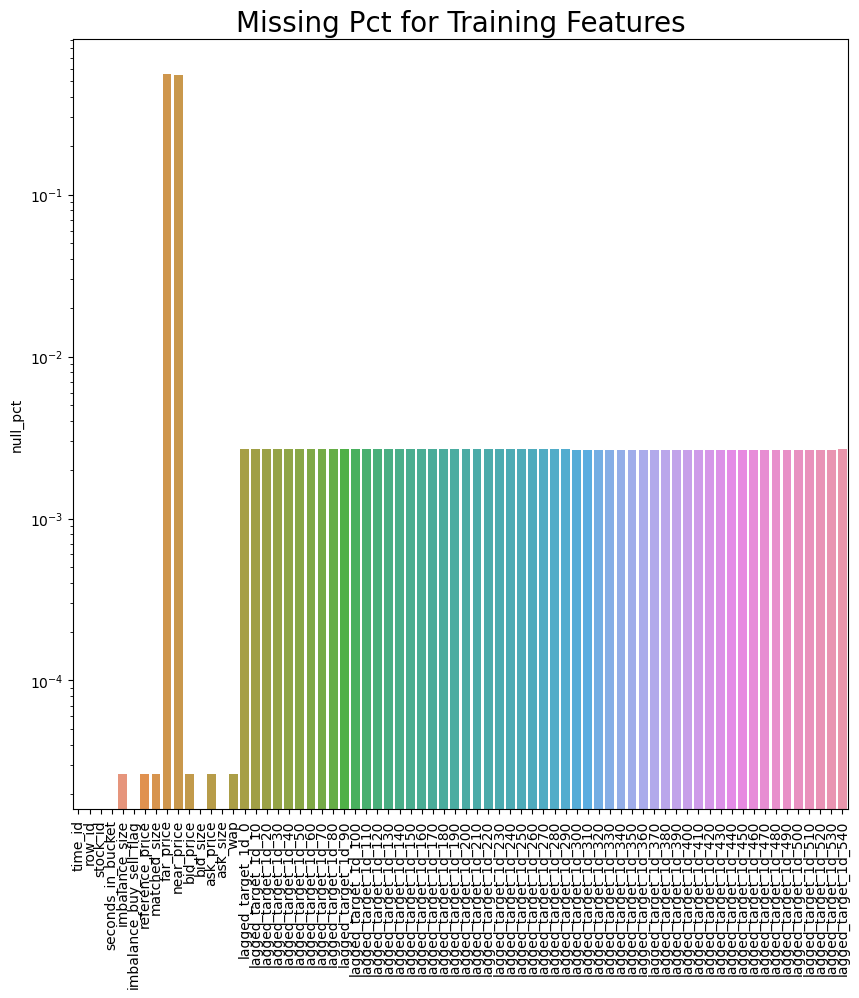

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_missing = X_other.isnull().mean().to_frame().rename(columns={0: 'null_pct'})
sns.barplot(plot_missing, x=plot_missing.index, y='null_pct', log=True)
plt.xticks(rotation=90)
plt.title('Missing Pct for Training Features', fontsize=20)
plt.savefig('../figures/EDA/missing_pct.png')

# Preprocessing

- Drop: date_id (already excluded), time_id, row_id
- Categorical: imbalance_buy_sell_flag, stock_id --> One-Hot Encoding
- MinMax Scaler: seconds in bucket
- All the remaining features are continuous: Standard Scaler

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

submission_id = X_test[identifier_cols]

# Split train-validation data: cross validation applied
len_group_other = groups_other.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group_other*0.25), n_splits=1)
for i_train, i_val in gts.split(X_other, y_other, groups_other):
    print("Train index:", i_train, "Val index:", i_val)
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]

Train index: [      0       1       2 ... 3126362 3126363 3126364] Val index: [3126365 3126366 3126367 ... 4181977 4181978 4181979]


In [8]:
# Drop id columns
dropped_ftrs = identifier_cols

# collect which encoder to use on each feature
onehot_ftrs = ['imbalance_buy_sell_flag','stock_id']
minmax_ftrs = ['seconds_in_bucket']
std_ftrs = features[2:] + lagged_cols


# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 

# Fit and transform
X_train = X_train.drop(columns=dropped_ftrs)
X_val = X_val.drop(columns=dropped_ftrs)
X_test = X_test.drop(columns=dropped_ftrs)
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train_prep.shape)
print(X_train_prep)

(3126365, 269)
[[0.         0.         1.         ...        nan        nan        nan]
 [1.         0.         0.         ...        nan        nan        nan]
 [1.         0.         0.         ...        nan        nan        nan]
 ...
 [0.         1.         0.         ... 0.15647921 0.35225916 0.32141943]
 [0.         0.         1.         ... 0.61385393 0.43100641 0.74933427]
 [0.         0.         1.         ... 0.29560753 0.27363213 0.76792918]]


In [35]:
preprocessor

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['imbalance_buy_sell_flag', 'stock_id']),
                                ('minmax', MinMaxScaler(),
                                 ['seconds_in_bucket']),
                                ('std', StandardScaler(),
                                 ['imbalance_size', 'imbalance_buy_sell_flag',
                                  'reference_price', 'matched_size',
                                  'far_price', 'near_price', 'bid_price',
                                  'bid_size', 'ask_price',...
                                  'lagged_target_1d_20', 'lagged_target_1d_30',
                                  'lagged_target_1d_40', 'lagged_target_1d_50',
                                  'lagged_target_1d_60', 'lagged_target_1d_70',
                                  'lagged_target_1d_80', 'lagged_target_1d_90',
                                  'lagged_target_1d_100',
                                  'lagged_target_1d_110',
                                  'lagged_target_1d_120',
                                  'lagged_target_1d_130',
                                  'lagged_target_1d_140',
                                  'lagged_target_1d_150',
                                  'lagged_target_1d_160',
                                  'lagged_target_1d_170',
                                  'lagged_target_1d_180', ...])])